In [2]:
import matplotlib.pyplot as plt

import tensorflow as tf
import PIL
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dropout, Dense, Softmax)
from tensorflow.keras.applications import mobilenet as _mobilenet
import random
import os
import numpy as np
from PIL import Image
import networkx as nx
from sklearn.neighbors import NearestNeighbors
from IPython.display import Image as iImage
from IPython.display import display
import math

import pickle

In [15]:
def normalise(train, p):
    min_d = np.min(train)
    max_d = np.max(train)
    normalised_p = (p-min_d)/(max_d - min_d)
    return normalised_p

In [16]:
def denormalise(train, p):
    min_d = np.min(train)
    max_d = np.max(train)
    denormalised_p = p * (max_d - min_d) + min_d
    return denormalised_p

In [23]:
# Return the (g,h) index of the BMU in the grid
def find_BMU(SOM,x):
    distSq = (np.square(SOM - x)).sum(axis=2)
    return np.unravel_index(np.argmin(distSq, axis=None), distSq.shape)

# Update the weights of the SOM cells when given a single training example
# and the model parameters along with BMU coordinates as a tuple
def update_weights(SOM, train_ex, learn_rate, radius_sq, 
                   BMU_coord, step=3):
    g, h = BMU_coord
    #if radius is close to zero then only BMU is changed
    if radius_sq < 1e-3:
        SOM[g,h,:] += learn_rate * (train_ex - SOM[g,h,:])
        return SOM
    # Change all cells in a small neighborhood of BMU
    for i in range(max(0, g-step), min(SOM.shape[0], g+step)):
        for j in range(max(0, h-step), min(SOM.shape[1], h+step)):
            dist_sq = np.square(i - g) + np.square(j - h)
            dist_func = np.exp(-dist_sq / 2 / radius_sq)
            SOM[i,j,:] += learn_rate * dist_func * (train_ex - SOM[i,j,:])   
    return SOM    

# Main routine for training an SOM. It requires an initialized SOM grid
# or a partially trained grid as parameter
def train_SOM(SOM, train_data, learn_rate = .1, radius_sq = 1, 
             lr_decay = .1, radius_decay = .1, epochs = 10):    
    learn_rate_0 = learn_rate
    radius_0 = radius_sq
    for epoch in np.arange(0, epochs):
        rand.shuffle(train_data)      
        for train_ex in train_data:
            g, h = find_BMU(SOM, train_ex)
            SOM = update_weights(SOM, train_ex, 
                                 learn_rate, radius_sq, (g,h))
        # Update learning rate and radius
        learn_rate = learn_rate_0 * np.exp(-epoch * lr_decay)
        radius_sq = radius_0 * np.exp(-epoch * radius_decay)            
    return SOM

In [8]:
import sklearn

def euclidean(a, b):
    return np.linalg.norm(a-b)

def u_matrix(lattice):
    """Builds a U-matrix on top of the trained lattice.

        Parameters
        ---
        lattice : list

            The SOM generated lattice

        Returns
        ---
        The lattice of the shape (R,C):

        R - number of rows; C - number of columns;
        """
    X, Y, Z = lattice.shape
    u_values = np.empty((X,Y), dtype=np.float64)

    for y in range(Y):
        for x in range(X):
            current = lattice[x,y]
            dist = 0
            num_neigh = 0
            # left
            if x-1 >= 0:
                #middle
                vec = lattice[x-1,y]
                dist += euclidean(current, vec)
                num_neigh += 1
                if y - 1 >= 0:
                    #sup
                    vec = lattice[x-1, y-1]
                    dist += euclidean(current, vec)
                    num_neigh += 1
                if y + 1 < Y:
                    # down
                    vec = lattice[x-1,y+1]
                    dist += euclidean(current, vec)
                    num_neigh += 1
            # middle
            if y - 1 >= 0:
                # up
                vec = lattice[x,y-1]
                dist += euclidean(current, vec)
                num_neigh += 1
            # down
            if y + 1 < Y:
                vec = lattice[x,y+1]
                dist += euclidean(current, vec)
                num_neigh += 1
            # right
            if x + 1 < X:
                # middle
                vec = lattice[x+1,y]
                dist += euclidean(current, vec)
                num_neigh += 1
                if y - 1 >= 0:
                    #up
                    vec = lattice[x+1,y-1]
                    dist += euclidean(current, vec)
                    num_neigh += 1
                if y + 1 < lattice.shape[1]:
                    # down
                    vec = lattice[x+1,y+1]
                    dist += euclidean(current, vec)
                    num_neigh += 1
            u_values[x,y] = dist / num_neigh
    u_values = (u_values - 1) * -1
    return u_values

In [82]:
def activate(train_data, SOM, p):
    normalP = normalise(train_data, p)
    activatedSOM = np.array([[euclidean(normalP, c) for c in r] for r in SOM])
    normalisedActivatedSOM = normalise(activatedSOM, activatedSOM)
    activatedSOM = (normalisedActivatedSOM -1)*(-1)
    return activatedSOM

In [27]:
import scipy
def calculateQE(SOM,data):
    sumSqDist = 0
    for d in data:
        g,h = find_BMU(SOM, d)
        v1 = SOM[g,h]
        v2 = d
        sumSqDist += scipy.spatial.distance.cdist([v1],[v2],'sqeuclidean')[0][0]
    QE = sumSqDist/len(data)
    return QE

def calculateTE(SOM,data):
    failed = 0
    for d in data:
        g1,h1 = find_BMU(SOM,d)
        g2,h2 = find_BMU_2(SOM,d)
        dist = scipy.spatial.distance.cityblock([g1,h1], [g2,h2])
        if dist>1:
            failed+=1
    return failed/len(data)

# Return the (g,h) index of the BMU in the grid
def find_BMU_2(SOM,x):
    distSq = (np.square(SOM - x)).sum(axis=2)
    return np.unravel_index(np.argpartition(distSq, 2, axis=None)[2], distSq.shape)

In [3]:
def load_image(img_file, target_size=(224,224)):
    X = np.zeros((1, *target_size, 3))
    X[0, ] = np.asarray(tf.keras.preprocessing.image.load_img(
        img_file, 
        target_size=target_size)
    )
    X = tf.keras.applications.mobilenet.preprocess_input(X)
    return X

def ensure_folder_exists(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

In [4]:
def processImage(imagePath, model):
    im = load_image(imagePath)
    f = model.predict(im)[0]
    return f

In [60]:
model = tf.keras.applications.mobilenet.MobileNet(
# The 3 is the three dimensions of the input: r,g,b.
  input_shape=(224, 224, 3), 
  include_top=False, 
  pooling='avg'
)

In [131]:
momaFiles = os.listdir('Image')
if '.DS_Store' in momaFiles:
    momaFiles.remove('.DS_Store')
momaFiles = momaFiles[:1000]

In [132]:
features = []
for m in momaFiles:
    path = os.path.join('Image', m)
    f = processImage(path, model)
    features.append(f)

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 24ms/step


In [133]:
momaFiles

['suda0.jpg',
 'suda1.jpg',
 'suda10.jpg',
 'suda102.jpg',
 'suda103.jpg',
 'suda104.jpg',
 'suda105.jpg',
 'suda11.jpg',
 'suda116.jpg',
 'suda118.jpg',
 'suda119.jpg',
 'suda120.jpg',
 'suda121.jpg',
 'suda122.jpg',
 'suda123.jpg',
 'suda124.jpg',
 'suda125.jpg',
 'suda127.jpg',
 'suda13.jpg',
 'suda130.jpg',
 'suda132.jpg',
 'suda133.jpg',
 'suda134.jpg',
 'suda135.jpg',
 'suda137.jpg',
 'suda138.jpg',
 'suda146.jpg',
 'suda147.jpg',
 'suda148.jpg',
 'suda149.jpg',
 'suda15.jpg',
 'suda151.jpg',
 'suda152.jpg',
 'suda153.jpg',
 'suda155.jpg',
 'suda156.jpg',
 'suda157.jpg',
 'suda16.jpg',
 'suda160.jpg',
 'suda165.jpg',
 'suda166.jpg',
 'suda167.jpg',
 'suda169.jpg',
 'suda17.jpg',
 'suda172.jpg',
 'suda174.jpg',
 'suda181.jpg',
 'suda184.jpg',
 'suda185.jpg',
 'suda188.jpg',
 'suda19.jpg',
 'suda194.jpg',
 'suda196.jpg',
 'suda197.jpg',
 'suda199.jpg',
 'suda2.jpg',
 'suda20.jpg',
 'suda200.jpg',
 'suda202.jpg',
 'suda206.jpg',
 'suda207.jpg',
 'suda208.jpg',
 'suda209.jpg',
 'suda

In [134]:
featureImagePairs = []
for i in range(len(features)):
    featureImage = {}
    featureImage['image'] = momaFiles[i]
    featureImage['feature'] = features[i]
    featureImagePairs.append(featureImage)

In [167]:
# Dimensions of the SOM grid
m = 10
n = 10
# Number of training examples
n_x = 200
rand = np.random.RandomState(0)
# Initialize the training data
train_data = features

# Normalised Training Data
n_train_data = normalise(train_data, train_data)

# Initialize the SOM randomly
SOM = rand.uniform(0, 1, (m, n, len(train_data[0])))

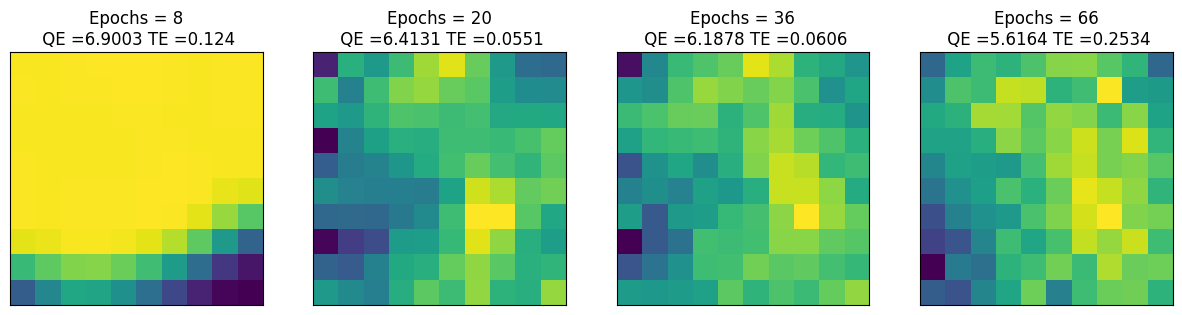

In [168]:
fig, ax = plt.subplots(
    nrows=1, ncols=4, figsize=(15, 3.5), 
    subplot_kw=dict(xticks=[], yticks=[]))
total_epochs = 0
SOMS = []
for epochs, i in zip([8, 12, 16, 30], range(0,4)):
    total_epochs += epochs
    SOM = train_SOM(SOM, n_train_data, learn_rate = .1, radius_sq = 2, epochs = epochs)
    SOMS.append(SOM)
    QE = round(calculateQE(SOM, n_train_data), 4)
    TE = round(calculateTE(SOM, n_train_data), 4)
    
    ax[i].imshow(u_matrix(SOM))
    ax[i].title.set_text('Epochs = ' + str(total_epochs) + '\n QE =' + str(QE) + ' TE =' + str(TE))

In [169]:
SOM = SOMS[2]

## 2.Write a function with which you can save a trained som using pickle

In [5]:
import pickle

def save_som(som, filename):
    with open(filename, 'wb') as f:
        pickle.dump(som, f)

In [184]:
save_som(SOM, 'som_model.pkl')

## 3.Write a function to load a saved som

In [3]:
def load_som(filename):
    with open(filename, 'rb') as f:
        som = pickle.load(f)
    return som

In [6]:
SOM = load_som('som_model.pkl')

In [188]:
SOMimages = []
for i in range(len(SOM)):
    row = []
    for j in range(len(SOM[0])):
        row.append([])
    SOMimages.append(row)

In [189]:
for fi in featureImagePairs:
    g,h = find_BMU(SOM, normalise(train_data, fi['feature']))
    SOMimages[g][h].append(fi)

## 4.When filling the SOM with images, make sure that the images that are displayed are in fact the images that are closest to the SOM vector of that particular cell

In [199]:
from scipy import spatial

def closest_images_grid(SOMimages, SOM):
    
    imageGrid = []
    
    for g in range(len(SOMimages)):
        row = SOMimages[g]
        for h in range(len(row)):
            cell = row[h]
            if len(cell) > 0:
                #Find the image closest to the SOM vector
                closest_image = min(cell, key=lambda x: spatial.distance.cosine(x['feature'], SOM[g][h]))
                imageGrid.append(closest_image['image'])
            else:
                imageGrid.append('white.png')
    return imageGrid

In [203]:
imageGrid = closest_images_grid(SOMimages, SOM)

In [191]:
def img_reshape(img):
    img = Image.open('Image/'+img).convert('RGB')
    img = img.resize((100,100))
    img = np.asarray(img)
    return img

## 5.Write a function that returns a grid of images where each image is the closest image from the training data set to that cell in the SOM.

In [211]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

def plot_image_grid(imageGrid,grid_shape=(10, 10), figsize=(20., 20.), axes_pad=0.1):
    
    img_arr = []
    for image in imageGrid:
        img_arr.append(img_reshape(image))

    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111, 
                     nrows_ncols=grid_shape,  
                     axes_pad=axes_pad,
                     )

    for ax, im in zip(grid, img_arr):
        ax.imshow(im)
        ax.axis('off')

    plt.show()

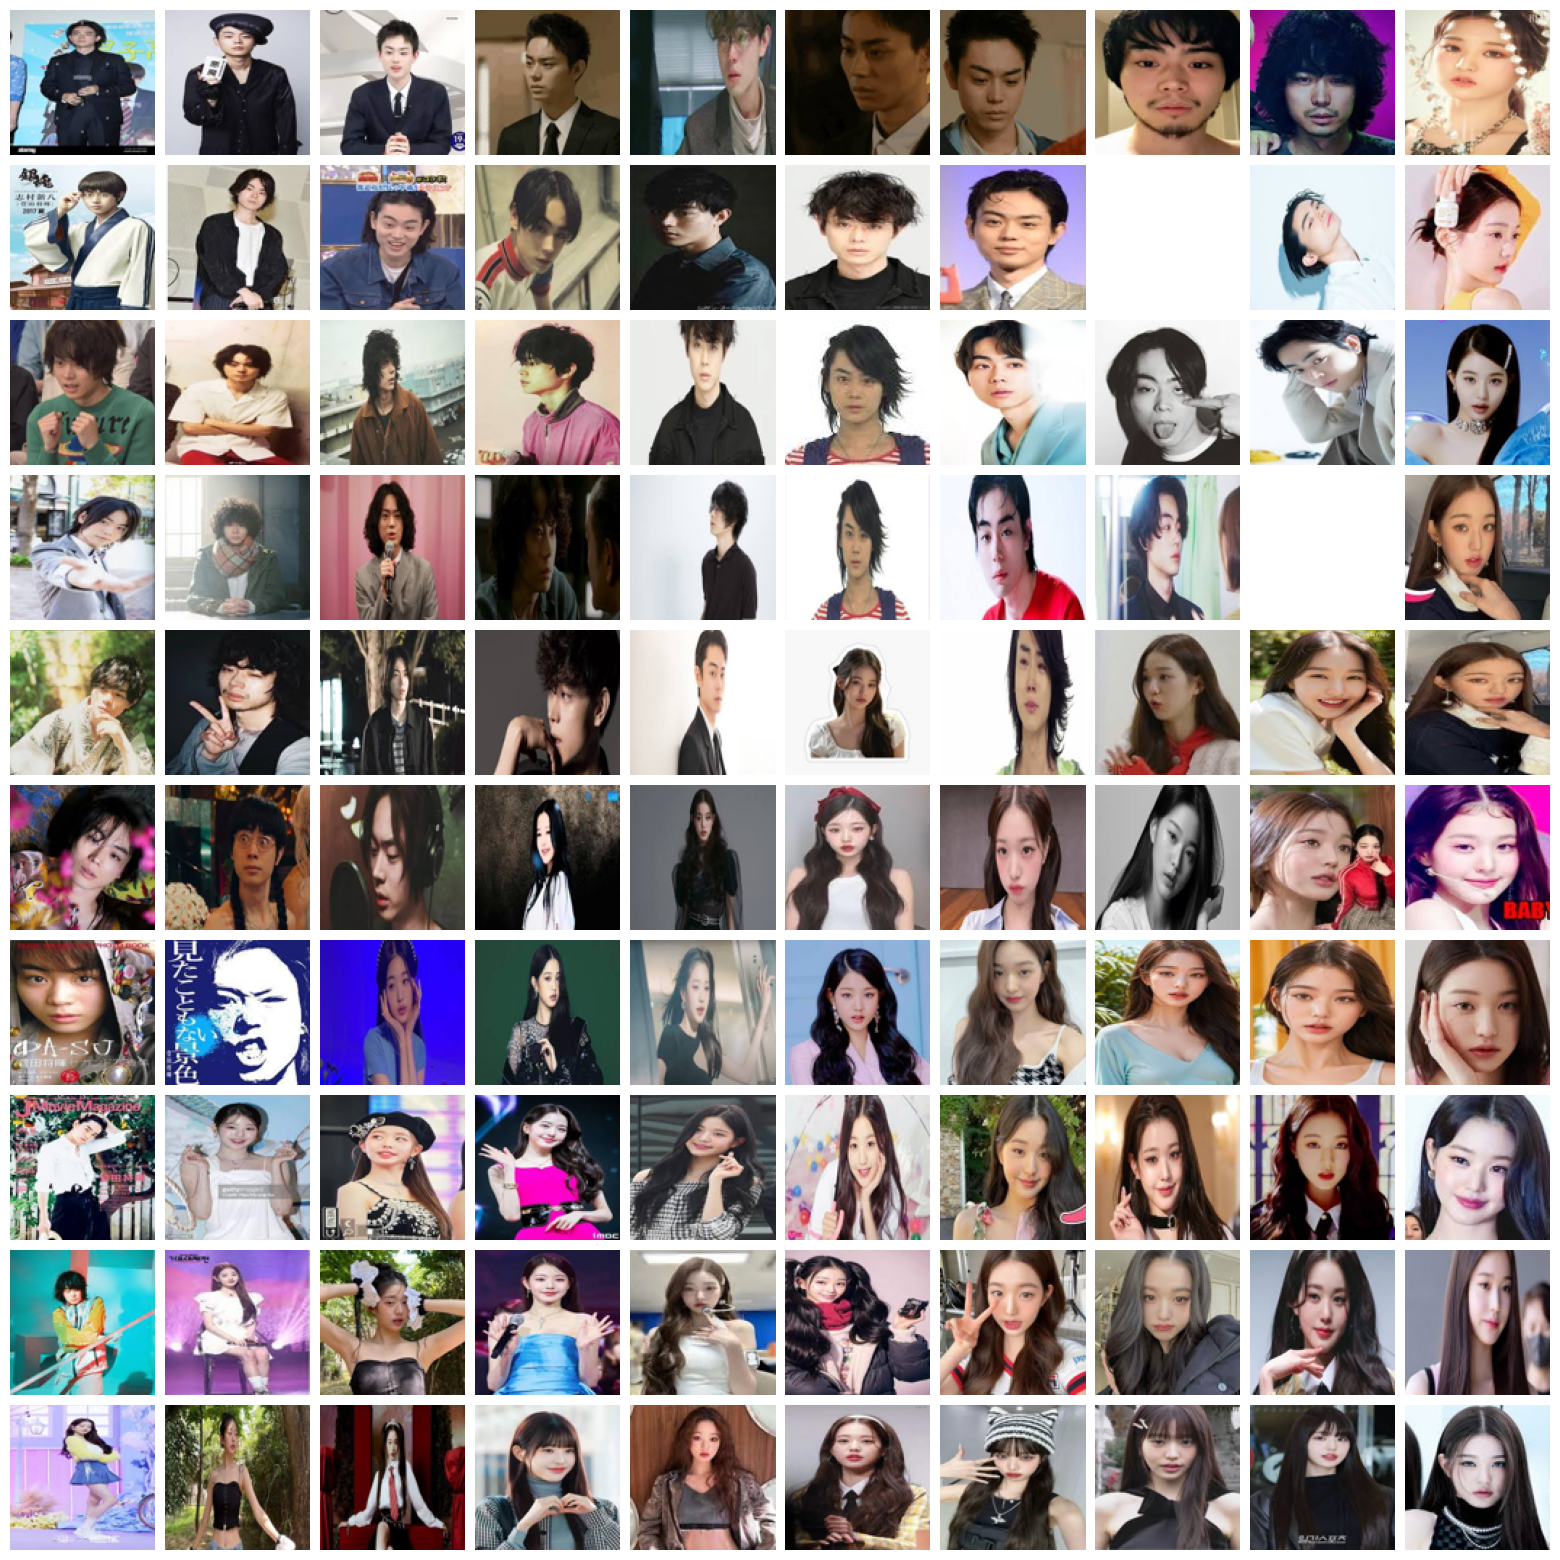

In [212]:
plot_image_grid(imageGrid)

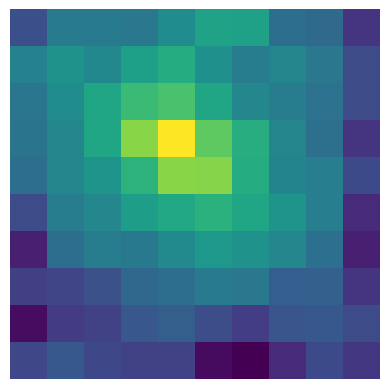

In [206]:
activatedSOM = activate(train_data, SOM, normalise(train_data,featureImagePairs[0]['feature']))
fig = plt.figure()
plt.imshow(activatedSOM)
plt.axis('off')
plt.show()

## 6.Make a function to visualise a uMatrix using your own colour gradient.

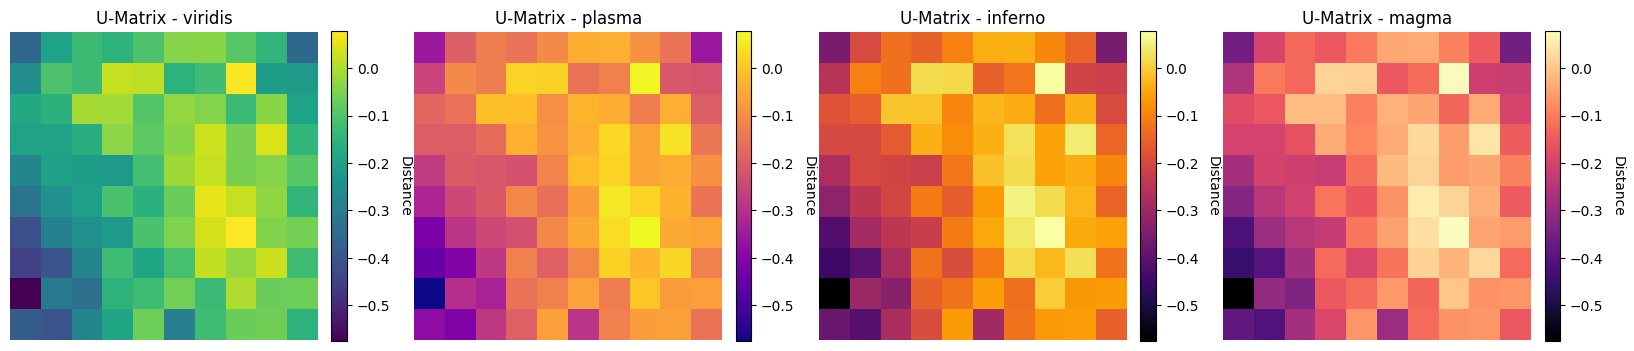

In [16]:
import matplotlib.pyplot as plt

def visualize_umatrix_with_gradients(SOM, colors):
    gradients = ['viridis', 'plasma', 'inferno', 'magma']

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    for i, gradient in enumerate(gradients):
        umatrix = u_matrix(SOM)
        ax = axs[i]
        im = ax.imshow(umatrix, cmap=colors[i])
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Distance', rotation=270, labelpad=15)
        ax.set_title(f'U-Matrix - {gradient}')
        ax.axis('off')

    plt.show()

colors = ['viridis', 'plasma', 'inferno', 'magma']
visualize_umatrix_with_gradients(SOM, colors)

##  7.Train a SOM with a different way of vectorising a dataset, this could be text using TF-IDF, or any other alternative which which you can encode a dataset into a numerical vector. The vectors should have at least 4 dimensions.